In [1]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os
import random
import seaborn as sns
import torch,torchvision
from  matplotlib import pyplot as plt
from PIL import Image 
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools
import torchvision.utils as vutils
from torchvision import transforms, models
import json
import cv2
import random
from bs4 import BeautifulSoup
import torchvision
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from matplotlib.patches import Rectangle
%matplotlib inline

In [2]:
# Для воспроизводимости результатов зафиксируем сиды:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True

### Изучим имеющиеся данные

In [3]:
pwd = os.getcwd()
list_folders = os.listdir('detect_dataset')
print('Текущее расположение репозитория', pwd)
print('Список папок', list_folders)

Текущее расположение репозитория d:\Python_notebooks\repository_Koldim2001\Hardhat_detector
Список папок ['annotations', 'images', 'тестовое ЦТиП.pdf']


Определим число фотографий в имеющемся датасете:

In [4]:
len(os.listdir('detect_dataset/images'))

500

#### Поработаем с данными, которые лежат в json формате

Раскроем json файл с размеченными bounding boxes:

In [5]:
path_json = 'detect_dataset/annotations/COCO_json/coco_annotations_train.json'

with open(path_json) as train_file:
    dict_train = json.load(train_file)

train_images_info = pd.DataFrame.from_dict(dict_train['images'])

Посмотрим, как выглядят данные в таблице с информацией о фотографиях:

In [6]:
train_images_info.head()

,id,width,height,file_name,license,flickr_url,coco_url,date_captured
0,1,1920,1080,oz_frame548.jpg,0,,,0
1,2,1920,1080,oz_frame547.jpg,0,,,0
2,3,1920,1080,oz_frame546.jpg,0,,,0
3,4,1920,1080,oz_frame538.jpg,0,,,0
4,5,1920,1080,oz_frame537.jpg,0,,,0


Определим какие есть уникальные значения высоты и ширины изображений в датасете:

In [7]:
print('ширина:', train_images_info.width.unique())
print('высота', train_images_info.height.unique())

ширина: [1920]
высота [1080]


Таким образом, все 500 фотографий в датасете имеют одинаковые размеры 1920:1080

Переименуем столбец id в image_id и оставим лишь столбец file_name помимо него

In [8]:
train_images_info = train_images_info.rename(columns={'id': 'image_id'})
train_images_info = train_images_info[['image_id', 'file_name']]
print(train_images_info.head())

   image_id        file_name
0         1  oz_frame548.jpg
1         2  oz_frame547.jpg
2         3  oz_frame546.jpg
3         4  oz_frame538.jpg
4         5  oz_frame537.jpg


Посмотрим на то, как выглядят данные по bounding боксам:

In [9]:
train_annotations_info = pd.DataFrame.from_dict(dict_train['annotations'])
train_annotations_info.head()

,id,image_id,category_id,segmentation,area,bbox,iscrowd,attributes
0,1,1,1,[],9660.2286,"[838.78, 268.37, 59.62, 162.03]",0,{'occluded': False}
1,2,1,1,[],3926.2467,"[841.61, 244.27, 62.49, 62.83]",0,{'occluded': False}
2,3,2,1,[],5005.3252,"[879.56, 243.42, 47.14, 106.18]",0,{'occluded': False}
3,4,2,1,[],9034.6585,"[841.61, 266.95, 53.89, 167.65]",0,{'occluded': False}
4,5,3,1,[],11517.0484,"[838.78, 265.53, 68.12, 169.07]",0,{'occluded': False}


Cделаем inner join этих двух таблиц по ключу image_id

In [10]:
df_data = pd.merge(train_images_info, train_annotations_info, on='image_id')\
    [['image_id', 'file_name', 'category_id', 'bbox']]
df_data

,image_id,file_name,category_id,bbox
0,1,oz_frame548.jpg,1,"[838.78, 268.37, 59.62, 162.03]"
1,1,oz_frame548.jpg,1,"[841.61, 244.27, 62.49, 62.83]"
2,2,oz_frame547.jpg,1,"[879.56, 243.42, 47.14, 106.18]"
3,2,oz_frame547.jpg,1,"[841.61, 266.95, 53.89, 167.65]"
4,3,oz_frame546.jpg,1,"[838.78, 265.53, 68.12, 169.07]"
...,...,...,...,...
910,496,am3_1_frame021.jpg,1,"[787.94, 401.03, 169.31, 438.42]"
911,497,am3_1_frame015.jpg,1,"[789.72, 417.07, 158.62, 470.49]"
912,498,am3_1_frame007.jpg,1,"[779.03, 458.06, 201.39, 522.18]"
913,499,am3_1_frame006.jpg,1,"[759.43, 470.54, 201.38, 536.43]"


In [11]:
df_data.category_id.value_counts()

category_id
1    915
Name: count, dtype: int64

Таким образом, имеется лишь один класс размеченный - это человек <br>
Определим сколько боксов на каждой фотографии

In [12]:
df_amount_objects = df_data.groupby('file_name', as_index=False).agg({'bbox':'count'})\
    .rename(columns={'bbox':'amount_objects'})
df_amount_objects.head()

,file_name,amount_objects
0,am3_1_frame004.jpg,1
1,am3_1_frame006.jpg,1
2,am3_1_frame007.jpg,1
3,am3_1_frame015.jpg,1
4,am3_1_frame021.jpg,1


Число объектов на фотографиях:

In [13]:
df_amount_objects.amount_objects.value_counts()

amount_objects
2    357
1    114
3     29
Name: count, dtype: int64

Сделаем представление информации о боксах для фотографий как массив массивов:

In [14]:
def func(data):
    return list(data)


df_box_info = df_data.groupby('file_name', as_index=False).agg({'bbox': func})
df_box_info

,file_name,bbox
0,am3_1_frame004.jpg,"[[747.38, 507.21, 235.25, 572.79]]"
1,am3_1_frame006.jpg,"[[759.43, 470.54, 201.38, 536.43]]"
2,am3_1_frame007.jpg,"[[779.03, 458.06, 201.39, 522.18]]"
3,am3_1_frame015.jpg,"[[789.72, 417.07, 158.62, 470.49]]"
4,am3_1_frame021.jpg,"[[787.94, 401.03, 169.31, 438.42]]"
...,...,...
495,oz_violation_frame545.jpg,"[[947.92, 237.2, 90.78, 179.0], [840.2, 262.7,..."
496,oz_violation_frame560.jpg,"[[860.0, 274.76, 81.6, 244.54], [970.5, 290.5,..."
497,oz_violation_frame561.jpg,"[[870.12, 282.28, 79.58, 235.92], [1001.77, 28..."
498,oz_violation_frame562.jpg,"[[998.94, 292.46, 65.26, 203.14], [885.25, 278..."


In [15]:
# Переведем это в словарь с ключом в виде имени файла и значением в виде массива массивов из боксов
dict_box_info = dict(zip(list(df_box_info.file_name), list(df_box_info.bbox)))

In [16]:
# загрузка изображений в словарь (ключ - имя файла)
img_dict = {}
for file in df_data['file_name'].unique():
    img = cv2.imread(f'detect_dataset/images/{file}')
    img_dict[file] = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

Отобразим случайные 2 фотки с боксами из имеющегося датасета:

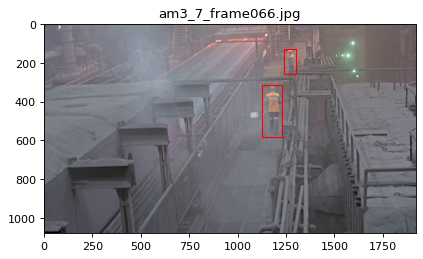

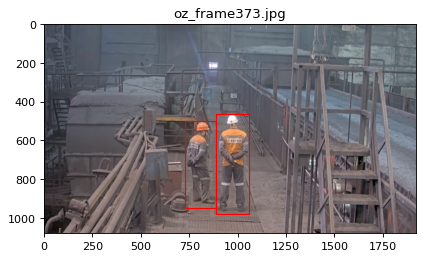

In [17]:
# Реализация с помощью matplotlib
random_img = random.sample(list(img_dict.keys()), 2)
for file_name in random_img:
    image = img_dict[file_name]
    boxes = dict_box_info[file_name]
    plt.figure(figsize=(6, 4), dpi=80)
    plt.imshow(image)
    plt.title(f'{file_name}')
    for box in boxes:
        x, y, w, h = map(int, box)
        plt.gca().add_patch(Rectangle((x,y), w, h,
            edgecolor='red',
            facecolor='none',
            lw= 1 )) 
    plt.show()     

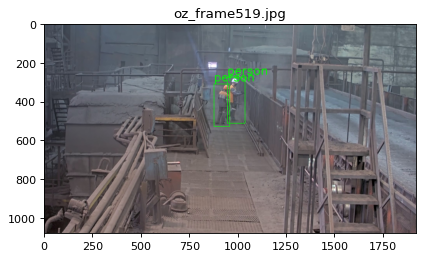

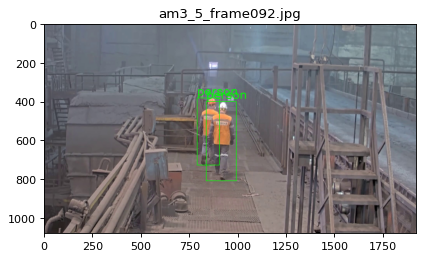

In [18]:
# Реализация с помощью cv2
random_img = random.sample(list(img_dict.keys()), 2)
for file_name in random_img:
    image = img_dict[file_name]
    boxes = dict_box_info[file_name]
    plt.figure(figsize=(6, 4), dpi=80)
    plt.title(f'{file_name}')
    class_name = 'person'
    for box in boxes:
        x, y, w, h = map(int, box)
        image = cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        image = cv2.putText(image, class_name, (x, y - 15), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 3)
    plt.imshow(image)
    plt.show()

___

### Преподготовка данных для обучения сети Faster RCNN:

Разделим данные на тренировочные и тестовые:

In [19]:
# Получим имена файлов без значения кодировки
names = []
for file in os.listdir('detect_dataset/images'):
    names.append(file.split('.')[0])

Рандомно поделим фотографии на train (80%) и test (20%)

In [20]:
train_data = random.sample(names, int(len(names) * 0.8))
print(f'Число изображений на train = {len(train_data)}')

Число изображений на train = 400


In [21]:
test_data = list(set(names) - set(train_data))
print(f'Число изображений на test = {len(test_data)}')

Число изображений на test = 100


Только что мы поработали с данными в формате json. Теперь рассмотрим как работать работать с аналогичными данными, но представленными в формате xml

In [22]:
with open('detect_dataset/annotations/PASCAL_VOC_xml/oz7_violation_frame519.xml') as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')
        num_objs = len(objects)
print(objects)

[<object>
<name>person</name>
<truncated>0</truncated>
<occluded>0</occluded>
<difficult>0</difficult>
<bndbox>
<xmin>1000.3</xmin>
<ymin>301.6</ymin>
<xmax>1082.3</xmax>
<ymax>514.5</ymax>
</bndbox>
</object>, <object>
<name>person</name>
<truncated>0</truncated>
<occluded>0</occluded>
<difficult>0</difficult>
<bndbox>
<xmin>1140.9</xmin>
<ymin>260.36</ymin>
<xmax>1215.6</xmax>
<ymax>493.2</ymax>
</bndbox>
</object>]


В данном случае информативная информация представлена в разделе _xmin_, _ymin_, _xmax_, _ymax_ и сам класс представлен в разделе _name_

In [23]:
# Создадим функции, которые как раз распарсят эти данные:
def generate_box(obj):
    xmin = int(float(obj.find('xmin').text))
    ymin = int(float(obj.find('ymin').text))
    xmax = int(float(obj.find('xmax').text))
    ymax = int(float(obj.find('ymax').text))
    return [xmin, ymin, xmax, ymax]

# класс человек - 1
def generate_label(obj):
    if obj.find('name').text == "person":
        return 1
    return 0

Pytorch как раз при обучении для моделей детекции тредует данные в формате [xmin, ymin, xmax, ymax] для каждого бокса

In [24]:
'''
Эта функция будет выдавать на выходе словарь с 3 ключами: boxes, labels и image_id.
На вход функция принимает:
image_id - индекс фотки из Dataset класса Pytorch 
file - путь к xml файлу
'''
def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')
        num_objs = len(objects)

        # Будем итерироваться по листу, полученному после раскрытия xml файла:
        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # В данном случае всего 1 класс 
        labels = torch.as_tensor(labels, dtype=torch.int64)
        # переведем индекс торч тензор
        img_id = torch.tensor([image_id])

        # получим итоговый словарь для исследуемой фотографии
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id
        
        return target

In [25]:
path_annot = 'detect_dataset/annotations/PASCAL_VOC_xml/'
path_images = 'detect_dataset/images/'

In [26]:
class MakeDataset(Dataset):
    def __init__(self, data, transforms=None):
        self.transforms = transforms
        self.names_list = data

    def __getitem__(self, idx):
        name = self.names_list[idx]
        file_image = 'detect_dataset/images/' + str(name) + '.jpg'
        file_label = 'detect_dataset/annotations/PASCAL_VOC_xml/' + str(name) + '.xml'
        img = Image.open(file_image).convert("RGB")

        #Сделаем словарь с аннотацией с помощью ранее написанной функции:
        target = generate_target(idx, file_label)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.names_list)

In [27]:
data_transform = transforms.Compose([
        transforms.ToTensor()
    ])

In [28]:
train_dataset = MakeDataset(train_data, transforms=data_transform)

Посмотрим в каком формате данные харнятся в классе Датасет:

In [29]:
first = train_dataset[0]
features, labels = first
print(labels)

{'boxes': tensor([[ 392.,  575.,  680., 1080.],
        [1009.,  830., 1305., 1080.],
        [ 946.,  423., 1080.,  790.]]), 'labels': tensor([1, 1, 1]), 'image_id': tensor([0])}


---

In [30]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=4, collate_fn=collate_fn)

In [31]:
torch.cuda.is_available()

True

In [32]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [33]:
model = get_model_instance_segmentation(2)

d:\Program files 2.0\Anaconda\envs\GPU\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Program files 2.0\Anaconda\envs\GPU\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Демонстрация выходных данных в класса DataLoader

In [34]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
for imgs, annotations in train_data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(annotations)
    break

[{'boxes': tensor([[ 392.,  575.,  680., 1080.],
        [1009.,  830., 1305., 1080.],
        [ 946.,  423., 1080.,  790.]], device='cuda:0'), 'labels': tensor([1, 1, 1], device='cuda:0'), 'image_id': tensor([0], device='cuda:0')}, {'boxes': tensor([[1209.,  127., 1269.,  238.],
        [1175.,  155., 1249.,  329.]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'image_id': tensor([1], device='cuda:0')}, {'boxes': tensor([[1245.,   77., 1298.,  225.],
        [1291.,   78., 1341.,  225.]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'image_id': tensor([2], device='cuda:0')}, {'boxes': tensor([[ 776.,  494.,  917.,  847.],
        [1126.,  189., 1195.,  348.]], device='cuda:0'), 'labels': tensor([1, 1], device='cuda:0'), 'image_id': tensor([3], device='cuda:0')}]


In [35]:
num_epochs = 3
model.to(device)
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

len_dataloader = len(train_data_loader)

for epoch in range(num_epochs):
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in train_data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model([imgs[0]], [annotations[0]])
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')
        epoch_loss += losses
    print(epoch_loss)

Iteration: 1/100, Loss: 1.0322420597076416
Iteration: 2/100, Loss: 0.5314993858337402
Iteration: 3/100, Loss: 0.4557686150074005
Iteration: 4/100, Loss: 0.3608205318450928
Iteration: 5/100, Loss: 0.39796191453933716
Iteration: 6/100, Loss: 0.35083070397377014
Iteration: 7/100, Loss: 0.5852155089378357
Iteration: 8/100, Loss: 0.44727054238319397
Iteration: 9/100, Loss: 0.17009013891220093
Iteration: 10/100, Loss: 0.3326820433139801
Iteration: 11/100, Loss: 0.28661003708839417
Iteration: 12/100, Loss: 0.14862960577011108
Iteration: 13/100, Loss: 0.14380903542041779
Iteration: 14/100, Loss: 0.13507400453090668
Iteration: 15/100, Loss: 0.17103353142738342
Iteration: 16/100, Loss: 0.20875601470470428
Iteration: 17/100, Loss: 0.2072973996400833
Iteration: 18/100, Loss: 0.41072288155555725
Iteration: 19/100, Loss: 0.12084625661373138
Iteration: 20/100, Loss: 0.23879465460777283
Iteration: 21/100, Loss: 0.2245197743177414
Iteration: 22/100, Loss: 0.26697680354118347
Iteration: 23/100, Loss: 0.

тестирование:

In [265]:
name = test_data[17]
file_image = 'detect_dataset/images/' + str(name) + '.jpg'
image = Image.open(file_image).convert("RGB")
test_im = data_transform(image)

In [266]:
test_im.size()

torch.Size([3, 1080, 1920])

In [267]:
device = 'cpu'
model = model.to(device)

In [268]:
test_im = test_im[ None, :, :, :]
test_im = test_im.to(device)

In [269]:
model.eval()
preds = model(test_im)
preds

[{'boxes': tensor([[ 754.4659,  522.5803,  874.5791,  930.7663],
          [ 836.5839,  479.2756, 1013.7266,  954.8871],
          [   5.2610,  950.5646,  123.4371, 1078.1361]],
         grad_fn=<StackBackward0>),
  'labels': tensor([1, 1, 1]),
  'scores': tensor([0.9809, 0.9800, 0.6908], grad_fn=<IndexBackward0>)}]

In [270]:
test_im = test_im[0].to("cpu")
test_im = np.transpose(test_im,(1,2,0))
test_im.size()

torch.Size([1080, 1920, 3])

In [271]:
test_im = test_im.numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


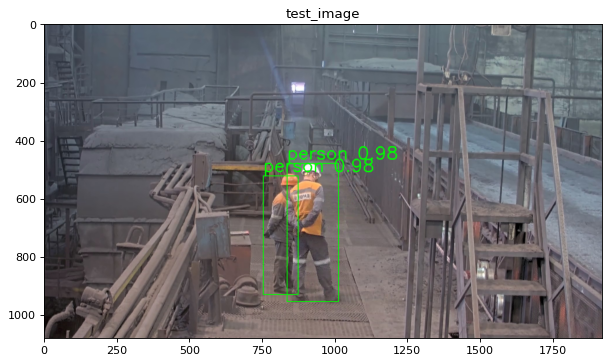

In [272]:
# Реализация построения результата детекции тестовой картинки
treshhold = 0.8  # Задалим порог. Если score больше порога, то выделяем бокс
plt.figure(figsize=(9, 7), dpi=80)
plt.title(f'test_image')
image = test_im.copy() 
class_detect = ['none','person']
for i in range(preds[0]['boxes'].size()[0]):
        if float(preds[0]['scores'][i]) > treshhold:
                [xmin, ymin, xmax, ymax] = preds[0]['boxes'][i]
                xmin = int(xmin)
                ymin = int(ymin)
                xmax = int(xmax)
                ymax = int(ymax)
                text = class_detect[int(preds[0]['labels'][i])] + ' ' + \
                  str(round(float(preds[0]['scores'][i]),2))
                image = cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
                image = cv2.putText(image, text, (xmin, ymin - 15),
                                    cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 255, 0), 3)
plt.imshow(image)
plt.show()